<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from scipy import stats
import cartopy.crs as ccrs
import shapely.geometry as sgeom

%matplotlib inline

In [2]:
def calc_clim(da):
    clim = da.groupby('time.month').mean('time')
    clim = clim*24*3600
    clim.attrs['units'] = 'm/s/day'
    
    rd = clim.coords.dims[1]
    #print(rd)
    vert_units = clim[rd].attrs['units']
    
    if vert_units == 'Pa':
        clim[rd] = clim[rd]/100.
        clim[rd].attrs['units'] = 'hPa'
        
    try:
        return clim.rename({rd: 'lev'})
    except:
        return clim
    
def ls_of_files(var, model):
    instr = f'/mnt/4data/CCMI/{model}/{var}_monthly_{model}_refC1SD_*_198001-201012.nc'
    #print(instr)
    files = glob.glob(instr)
    return files

In [3]:
ds_ogw = xr.open_dataset('/mnt/4data/CMAM/0A.monthly/accelogw_monPlev_CMAM_CMAM30-SD_r1i1p1_197901-201012.nc')
ds_ogw = ds_ogw.sel(time = slice('1980',None)) 

In [4]:
s_year = 1980
e_year = 1990
dec1 = calc_clim(ds_ogw.sel(time = slice(f'{s_year}-01', f'{e_year}-12')).accelogw)
s_year = 2000
e_year = 2010
dec2 = calc_clim(ds_ogw.sel(time = slice(f'{s_year}-01', f'{e_year}-12')).accelogw)

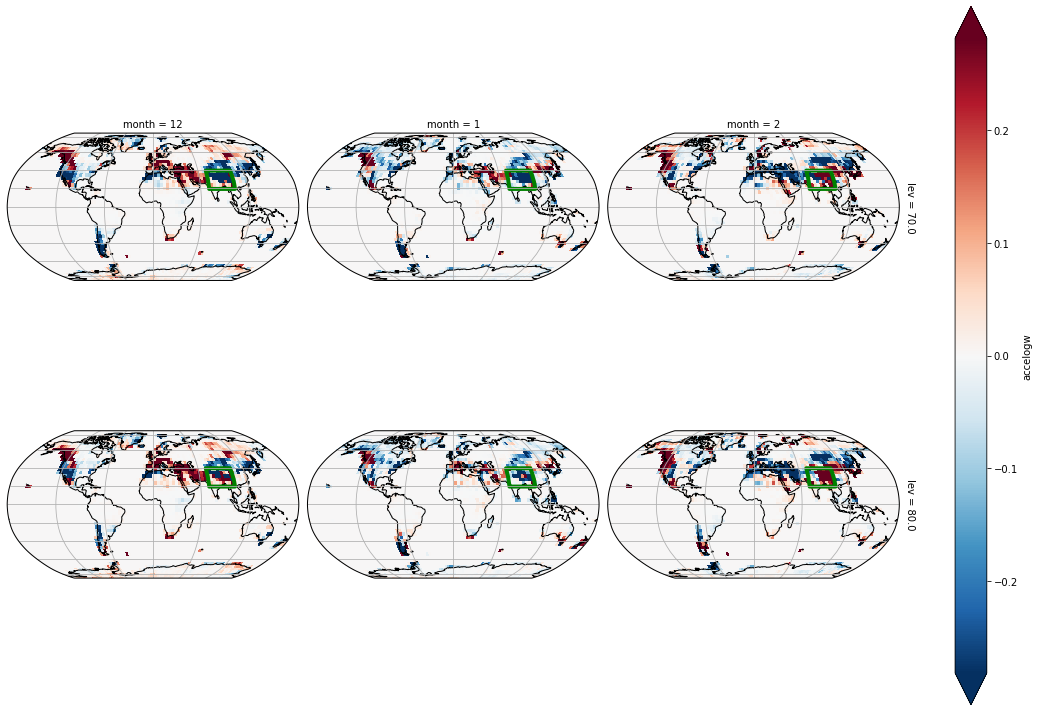

In [12]:
projection = ccrs.Robinson()#Orthographic(180, 90) vmax = 3
p = (dec2-dec1).sel(month = [12,1,2], \
                lev = [70,80]).plot(col = 'month', row = 'lev', \
                               transform=ccrs.PlateCarree(), \
                               robust = True, size = 5, \
                               subplot_kws={'projection': projection})
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
    box = sgeom.box(minx=70, maxx=102.5, miny=20, maxy=40)
    ax.add_geometries([box], ccrs.PlateCarree(), \
                      facecolor=['none'], edgecolor=['green'], \
                      linewidth = [4])

Text(0.5, 0, 'time')

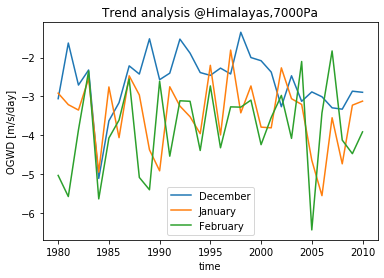

In [14]:
for ch_month, title in zip([12,1,2], titles):

    temp_sel = ds_ogw.accelogw.sel(plev = 8000, \
                        lon = slice(70,102.5),
                        lat = slice(20,40), 
                        time = (ds_ogw.time.dt.month == ch_month)).mean(['lat', 'lon'])*24*3600
    plt.plot(x, temp_sel, label = title)
plt.legend()
plt.title(f'Trend analysis @Himalayas,7000Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

Text(0.5, 0, 'time')

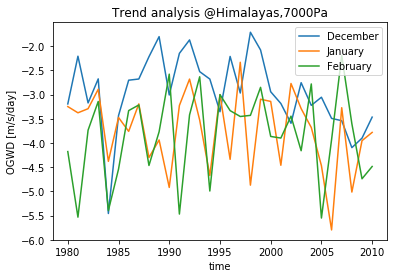

In [13]:
for ch_month, title in zip([12,1,2], titles):

    temp_sel = ds_ogw.accelogw.sel(plev = 7000, \
                        lon = slice(70,102.5),
                        lat = slice(20,40), 
                        time = (ds_ogw.time.dt.month == ch_month)).mean(['lat', 'lon'])*24*3600
    plt.plot(x, temp_sel, label = title)
plt.legend()
plt.title(f'Trend analysis @Himalayas,7000Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

0.13645835
month: 12, slope: -0.003117613878942305, med. slope: -0.0034638444582621255, -0.00880620214674208, 0.0019267797470092773
0.18433201
month: 1, slope: 0.0006625678510435159, med. slope: -0.0007082862513405937, -0.007484942674636841, 0.00797496239344279
0.19370112
month: 2, slope: -0.005682366677830296, med. slope: -0.005636200308799744, -0.014409174089846403, 0.0027621594759134147


Text(0.5, 0, 'time')

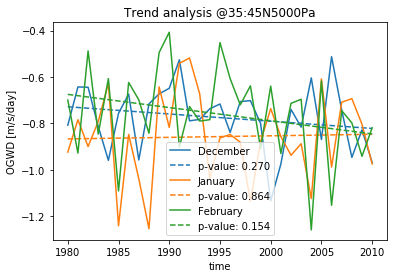

In [4]:
ch_plev = 5000
lat_start = 35
lat_end = 45

titles = ['December', 'January', 'February']
for ch_month, title in zip([12,1,2], titles):
    sel_dict = dict(plev = ch_plev, lat = slice(lat_start, lat_end), \
                    time = (ds_ogw.time.dt.month == ch_month))

    temp_sel = ds_ogw.accelogw.sel(**sel_dict).mean(['lat', \
                                                     'lon']).squeeze().values*24*3600#.plot(label = ch_month)#    .values#.plot.line(hue = 'ens')
    print(np.std(temp_sel[:]))

    x = np.arange(1980, 2011)
    p = plt.plot(x, temp_sel, label = title)
     # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, temp_sel, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp_sel)
    
    medslope, medintercept, lo_slope, up_slope = stats.theilslopes(temp_sel, x, 0.95)
    print(f'month: {ch_month}, slope: {slope}, med. slope: {medslope}, {lo_slope}, {up_slope}')
    fit_fn = np.poly1d(np.array([slope, intercept]))#fit)
    plt.plot(x, fit_fn(x), label = f'p-value: {p_value:3.3f}', color = p[0].get_color(), ls = '--')

plt.legend()
plt.title(f'Trend analysis @{lat_start}:{lat_end}N{ch_plev}Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

month: 12, slope: -0.0027931639023365514, med. slope: -0.00041136302446064194, -0.006737116724252701, 0.005235447333409236
month: 1, slope: -0.002480209041987696, med. slope: -0.0035044617123074, -0.008412712150149874, 0.0035754984075372868
month: 2, slope: -0.0013703765407685315, med. slope: -0.003430485725402832, -0.008806350438491158, 0.0035919646422068277


Text(0.5, 0, 'time')

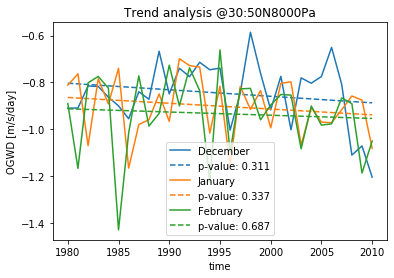

In [17]:
ch_plev = 8000
lat_start = 30
lat_end = 50

titles = ['December', 'January', 'February']
for ch_month, title in zip([12,1,2], titles):
    sel_dict = dict(plev = ch_plev, lat = slice(lat_start, lat_end), \
                    time = (ds_ogw.time.dt.month == ch_month))

    temp_sel = ds_ogw.accelogw.sel(**sel_dict).mean(['lat', \
                                                     'lon']).squeeze().values*24*3600#.plot(label = ch_month)#    .values#.plot.line(hue = 'ens')
    x = np.arange(1980, 2011)
    p = plt.plot(x, temp_sel, label = title)
     # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, temp_sel, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp_sel)
    
    medslope, medintercept, lo_slope, up_slope = stats.theilslopes(temp_sel, x, 0.95)
    print(f'month: {ch_month}, slope: {slope}, med. slope: {medslope}, {lo_slope}, {up_slope}')
    fit_fn = np.poly1d(np.array([slope, intercept]))#fit)
    plt.plot(x, fit_fn(x), label = f'p-value: {p_value:3.3f}', color = p[0].get_color(), ls = '--')

plt.legend()
plt.title(f'Trend analysis @{lat_start}:{lat_end}N{ch_plev}Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

month: 12, slope: 0.0015999823327987421, med. slope: 0.0018145527158464705, -0.004783010482788086, 0.008270773448442159
month: 1, slope: -0.0027234380043322038, med. slope: -0.00307290256023407, -0.008708600487027849, 0.0030751824378967285
month: 2, slope: 0.0009239479418723818, med. slope: -1.6490618387858074e-05, -0.006874875775698958, 0.008481794879550026


Text(0.5, 0, 'time')

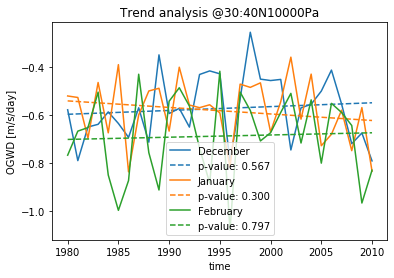

In [32]:
ch_plev = 10000
lat_start = 30
lat_end = 40

titles = ['December', 'January', 'February']
for ch_month, title in zip([12,1,2], titles):
    sel_dict = dict(plev = ch_plev, lat = slice(lat_start, lat_end), \
                    time = (ds_ogw.time.dt.month == ch_month))

    temp_sel = ds_ogw.accelogw.sel(**sel_dict).mean(['lat', \
                                                     'lon']).squeeze().values*24*3600#.plot(label = ch_month)#    .values#.plot.line(hue = 'ens')
    x = np.arange(1980, 2011)
    p = plt.plot(x, temp_sel, label = title)
     # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, temp_sel, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp_sel)
    
    medslope, medintercept, lo_slope, up_slope = stats.theilslopes(temp_sel, x, 0.95)
    print(f'month: {ch_month}, slope: {slope}, med. slope: {medslope}, {lo_slope}, {up_slope}')
    fit_fn = np.poly1d(np.array([slope, intercept]))#fit)
    plt.plot(x, fit_fn(x), label = f'p-value: {p_value:3.3f}', color = p[0].get_color(), ls = '--')

plt.legend()
plt.title(f'Trend analysis @{lat_start}:{lat_end}N{ch_plev}Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

month: 12, slope: -0.003186604957426748, med. slope: -0.0012318044900894165, -0.007350512619676261, 0.0036592533191045127
month: 1, slope: -0.001904588144633078, med. slope: -0.001613972442490714, -0.0061718503634134924, 0.002729799598455429
month: 2, slope: -5.399029581777511e-05, med. slope: 0.0005990028381347656, -0.005233114957809449, 0.00541465835911887


Text(0.5, 0, 'time')

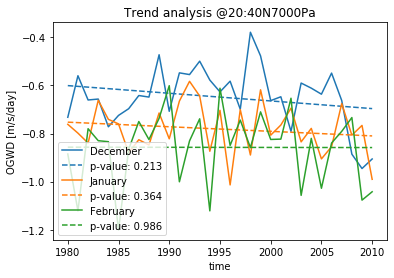

In [15]:
ch_plev = 7000
lat_start = 20
lat_end = 40

titles = ['December', 'January', 'February']
for ch_month, title in zip([12,1,2], titles):
    sel_dict = dict(plev = ch_plev, lat = slice(lat_start, lat_end), \
                    time = (ds_ogw.time.dt.month == ch_month))

    temp_sel = ds_ogw.accelogw.sel(**sel_dict).mean(['lat', \
                                                     'lon']).squeeze().values*24*3600#.plot(label = ch_month)#    .values#.plot.line(hue = 'ens')
    x = np.arange(1980, 2011)
    p = plt.plot(x, temp_sel, label = title)
     # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, temp_sel, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp_sel)
    
    medslope, medintercept, lo_slope, up_slope = stats.theilslopes(temp_sel, x, 0.95)
    print(f'month: {ch_month}, slope: {slope}, med. slope: {medslope}, {lo_slope}, {up_slope}')
    fit_fn = np.poly1d(np.array([slope, intercept]))#fit)
    plt.plot(x, fit_fn(x), label = f'p-value: {p_value:3.3f}', color = p[0].get_color(), ls = '--')

plt.legend()
plt.title(f'Trend analysis @{lat_start}:{lat_end}N{ch_plev}Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

month: 12, slope: -0.004606305735726511, med. slope: -0.0013858509063720704, -0.010076733430226643, 0.0036530249259051155
month: 1, slope: -0.0020185245621588918, med. slope: -0.0020797327160835266, -0.007357239723205566, 0.003662705421447754
month: 2, slope: -0.0022118871010118916, med. slope: -0.0046542644500732425, -0.010068174670724309, 0.00022639830907185873


Text(0.5, 0, 'time')

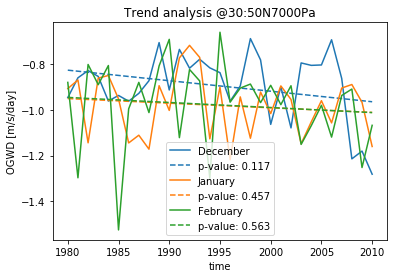

In [10]:
ch_plev = 7000
lat_start = 30
lat_end = 50

titles = ['December', 'January', 'February']
for ch_month, title in zip([12,1,2], titles):
    sel_dict = dict(plev = ch_plev, lat = slice(lat_start, lat_end), \
                    time = (ds_ogw.time.dt.month == ch_month))

    temp_sel = ds_ogw.accelogw.sel(**sel_dict).mean(['lat', \
                                                     'lon']).squeeze().values*24*3600#.plot(label = ch_month)#    .values#.plot.line(hue = 'ens')
    x = np.arange(1980, 2011)
    p = plt.plot(x, temp_sel, label = title)
     # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, temp_sel, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp_sel)
    
    medslope, medintercept, lo_slope, up_slope = stats.theilslopes(temp_sel, x, 0.95)
    print(f'month: {ch_month}, slope: {slope}, med. slope: {medslope}, {lo_slope}, {up_slope}')
    fit_fn = np.poly1d(np.array([slope, intercept]))#fit)
    plt.plot(x, fit_fn(x), label = f'p-value: {p_value:3.3f}', color = p[0].get_color(), ls = '--')

plt.legend()
plt.title(f'Trend analysis @{lat_start}:{lat_end}N{ch_plev}Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

In [19]:
ds_ogw = xr.open_dataset('/mnt/4data/CCMI/CMAM/accelogw_monthly_CMAM_refC1SD_r1i1p1_198001-201012.nc')
ds_ogw

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 48, lon: 1, plev: 31, time: 372)
Coordinates:
  * lon        (lon) float64 0.0
  * time       (time) object 1980-01-16 12:00:00 ... 2010-12-16 12:00:00
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 50.0 30.0 20.0 10.0
  * lat        (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float64 ...
    time_bnds  (time, bnds) object ...
    plev_bnds  (plev, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    accelogw   (time, plev, lat, lon) float32 ...
Attributes:
    institution:            CCCma (Canadian Centre for Climate Modelling and ...
    institute_id:           CCCma
    experiment_id:          refC1SD
    source:                 CMAM 2016
    model_id:               CMAM
    forcing:                N/A
    parent_experiment_id:   N/A
    parent_experiment_rip:  N/A
    branch_time:            0.0
    contact:                cccma_info@ec.gc.ca
    references:             http://www.cccma.ec.gc.ca/models
    initialization_method:  1
    physics_version:        1
    tracking_id:            41330b8c-c703-4aa1-abef-03c6cda5793c
    CCCma_runid:            ccmi1_dp963r
    CCCma_data_licence:     1) GRANT OF LICENCE - The Government of Canada (E...
    product:                output
    experiment:             Hindcast - Specified Dynamics
    frequency:              mon
    creation_date:          2016-02-10T00:54:04Z
    history:                2016-02-10T00:54:04Z CMOR rewrote data to comply ...
    Conventions:            CF-1.4
    project_id:             CCMI1
    table_id:               Table monthly (31 October 2014) 03a489d65da9ed6ac...
    title:                  CMAM model output prepared for CCMI1 Hindcast - S...
    parent_experiment:      N/A
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.2

Text(0.5, 0, 'time')

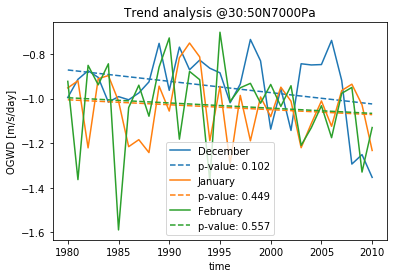

In [20]:
ch_plev = 7000
lat_start = 30
lat_end = 50

titles = ['December', 'January', 'February']
for ch_month, title in zip([12,1,2], titles):
    sel_dict = dict(plev = ch_plev, lat = slice(lat_start, lat_end), \
                    time = (ds_ogw.time.dt.month == ch_month))

    temp_sel = ds_ogw.accelogw.sel(**sel_dict).mean(['lat', \
                                                     'lon']).squeeze().values*24*3600#.plot(label = ch_month)#    .values#.plot.line(hue = 'ens')
    x = np.arange(1980, 2011)
    p = plt.plot(x, temp_sel, label = title)
     # = array([0, 1, 2, ..., 3598, 3599, 3600])
    fit = np.polyfit(x, temp_sel, 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, temp_sel)

    fit_fn = np.poly1d(np.array([slope, intercept]))#fit)
    plt.plot(x, fit_fn(x), label = f'p-value: {p_value:3.3f}', color = p[0].get_color(), ls = '--')

plt.legend()
plt.title(f'Trend analysis @{lat_start}:{lat_end}N{ch_plev}Pa')
plt.ylabel('OGWD [m/s/day]')
plt.xlabel('time')

In [21]:
ogw_ls = []
nogw_ls = []
dec_title_ls = []
for s_year in [1980,1990,2000]:
    e_year = s_year+10
    dec_title = f'{s_year}-{e_year}'
    dec_title_ls.append(dec_title)
    #da_nogw_clim = calc_clim(ds_nogw.accelnogw.sel(time = slice(f'{s_year}-01', f'{e_year}-12')))
    da_ogw_clim = calc_clim(ds_ogw.sel(time = slice(f'{s_year}-01', f'{e_year}-12')).accelogw)
    #nogw_ls.append(da_nogw_clim)
    ogw_ls.append(da_ogw_clim)
    
#nogw_dec = xr.concat(nogw_ls, dim='decade')
ogw_dec = xr.concat(ogw_ls, dim='decade')
ogw_dec['decade'] = dec_title_ls
#nogw_dec['decade'] = dec_title_ls
ogw_dec
    

<xarray.DataArray 'accelogw' (decade: 3, month: 12, lev: 31, lat: 48, lon: 1)>
array([[[[[ 7.39153052e-07],
          [ 7.39153052e-07],
          [-2.60748839e-05],
          ...,
          [ 1.84403895e-03],
          [-1.52456237e-03],
          [ 2.84395937e-05]],

         [[ 1.74148281e-05],
          [ 3.67638081e-01],
          [ 5.97594678e-02],
          ...,
          [ 5.71925007e-03],
          [-1.86217532e-01],
          [ 6.04383376e-06]],

         [[ 7.12455153e-01],
          [ 1.17167152e-01],
          [ 5.32314144e-02],
          ...,
          [ 2.07780823e-02],
          [ 4.52981405e-02],
          [ 3.33448907e-06]],

         ...,

         [[ 1.98264932e-03],
          [ 4.68033878e-03],
          [ 1.45766372e-03],
          ...,
          [-5.07923484e-01],
          [ 1.86739750e-02],
          [-2.57056742e-03]],

         [[ 5.09087369e-03],
          [ 1.35783413e-02],
          [ 1.19825574e-02],
          ...,
          [-7.99632490e-01],
          [ 1.56384900e-01],
          [-2.61330768e-03]],

         [[ 1.55469012e-02],
          [ 3.67538221e-02],
          [ 9.07345340e-02],
          ...,
          [-1.38967490e+00],
          [ 1.39660433e-01],
          [ 1.76017784e-04]]],


        [[[ 3.88638824e-07],
          [ 3.88638824e-07],
          [ 7.10451568e-05],
          ...,
          [ 1.76447642e-03],
          [-6.22961717e-03],
          [-1.78930604e-05]],

         [[ 1.09517096e-05],
          [ 5.79753637e-01],
          [ 7.31581375e-02],
          ...,
          [ 2.91146338e-03],
          [-4.12900567e-01],
          [-1.48238332e-05]],

         [[ 1.41777539e+00],
          [ 1.23961955e-01],
          [ 3.73582169e-02],
          ...,
          [ 2.29374901e-03],
          [-1.87177192e-02],
          [ 1.25766257e-06]],

         ...,

         [[-2.61374662e-04],
          [-8.72946461e-04],
          [-2.62784213e-03],
          ...,
          [-9.90588605e-01],
          [-2.23625615e-01],
          [-1.27136905e-03]],

         [[ 4.02247315e-05],
          [-2.30978651e-04],
          [-6.39028207e-04],
          ...,
          [-1.32567096e+00],
          [-1.58217937e-01],
          [-3.68026784e-03]],

         [[-2.50386423e-04],
          [ 1.45979429e-04],
          [-2.22152710e-04],
          ...,
          [-1.59239566e+00],
          [-2.27507979e-01],
          [-1.02488268e-02]]],


        [[[-7.92667763e-08],
          [-7.92667763e-08],
          [-4.65015946e-05],
          ...,
          [ 2.17458326e-03],
          [-7.33334105e-03],
          [-1.44639562e-05]],

         [[-8.37071366e-06],
          [ 1.11304712e+00],
          [ 9.28790793e-02],
          ...,
          [ 1.69041771e-02],
          [-3.17720622e-01],
          [-4.18280024e-06]],

         [[ 3.05135679e+00],
          [ 2.57213980e-01],
          [ 7.74511918e-02],
          ...,
          [-3.69172893e-03],
          [-1.05423238e-02],
          [ 2.94821575e-06]],

         ...,

         [[-3.51981334e-02],
          [-3.07189196e-01],
          [-1.14828002e+00],
          ...,
          [-3.03559989e-01],
          [-2.36834437e-02],
          [-2.30872858e-04]],

         [[-4.45503965e-02],
          [-3.74470890e-01],
          [-1.30011952e+00],
          ...,
          [-3.66823524e-01],
          [-3.11082248e-02],
          [-4.63485077e-04]],

         [[-4.30720150e-02],
          [-3.45586687e-01],
          [-1.02079010e+00],
          ...,
          [-4.97874767e-01],
          [-1.91952679e-02],
          [-1.15389594e-04]]],


        ...,


        [[[ 1.46494784e-07],
          [ 1.46494784e-07],
          [-1.72101154e-05],
          ...,
          [-1.51591026e-04],
          [-4.96066082e-03],
          [-2.36237975e-05]],

         [[-4.98327654e-06],
          [ 8.30403507e-01],
          [ 1.31838396e-01],
          ...,
          [ 2.48137210e-02],
          [-2.06388205e-01],
          [-1.58569146e-05]],

         [[ 3.75991845e+00],
      

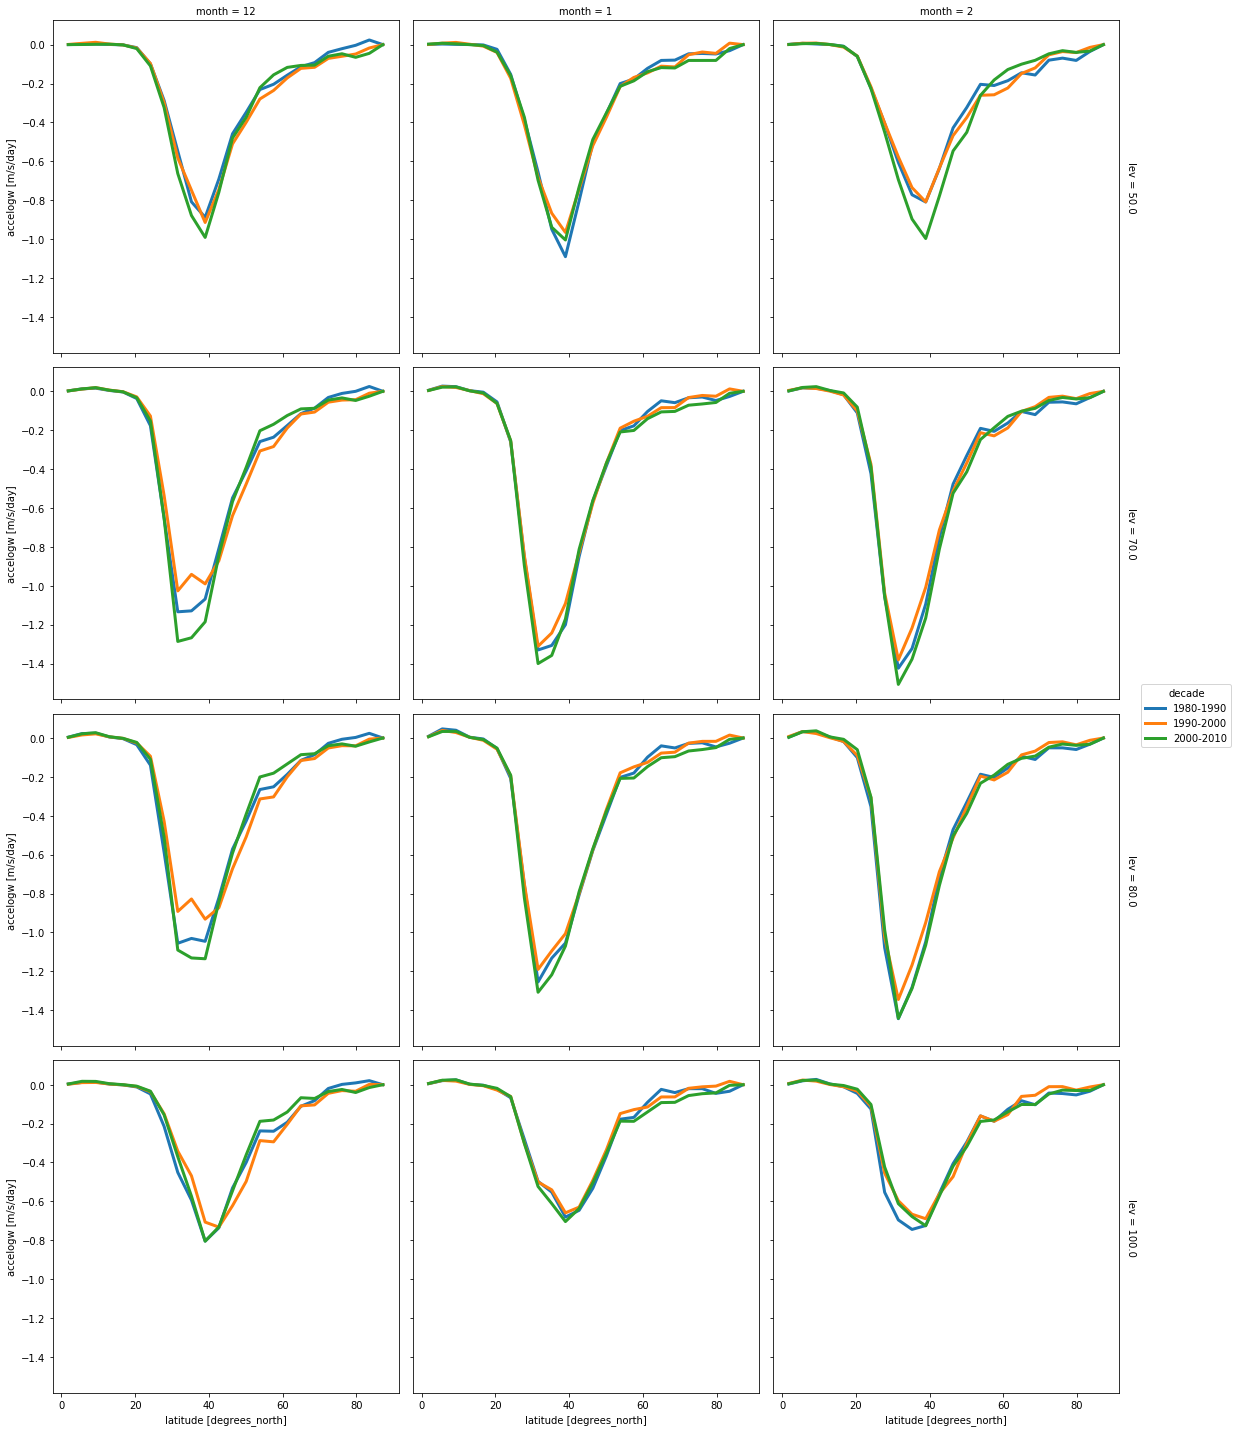

In [27]:
ogw_dec.sel(month = 
            [12,1,2], \
            lev = [50,70,80,100], \
            lat = slice(0,None)).squeeze().plot.line(hue = 'decade', col = 'month', row = 'lev', \
                                                     size = 5, lw = 3)